In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup


# Memo of processing
No need to repeat this step unless you really need

## making a master bias

```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'bias' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all \
    -o u/youtsumi/calib/bias/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/cpBias.yaml \
    --register-dataset-types \
    -j 8
```

## certify a master bias
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/bias/run_6806D /calib/run_6806D bias
```

## make LSST related info available in the repository
```
butler write-curated-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft LSSTCam 
```

## make a master dark 
```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'dark' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -o u/youtsumi/calib/dark/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/cpDark.yaml \
    --register-dataset-types \
    -j 8
```

got this error
```
RuntimeError: maskedImage bbox (minimum=(0, 0), maximum=(4607, 4095)) != biasMaskedImage bbox (minimum=(0, 0), maximum=(4095, 4003))
```
had to change doTrim=True

## certify a master dark
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/dark/run_6806D /calib/run_6806D dark
```

## make defects info
```
pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'bias' AND exposure.science_program IN ( '6806D' )" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -o u/youtsumi/calib/defects/run_6806D \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/findDefects.yaml \
    --register-dataset-types \
    -j 8    
```

## ceretify it
```
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft u/youtsumi/calib/defects/run_6806D /calib/run_6806D defects
```

## run spot task
```
PYTHONPATH=mixcoatl/python:$PYTHONPATH pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_6806D \
    -d "instrument='LSSTCam' AND exposure.observation_type='spot' AND exposure.science_program IN ( '6864D' )" \
    -o u/youtsumi/spot/1st \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types -j 8
```

In [2]:
# Import necessary libraries
from lsst.daf.butler import Butler
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import numpy

# Define a handy plot routine
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')


# point to the Repo we are working on, these lines will print out what's in the Repo.
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/youtsumi/calib/bias/run_6806D
u/youtsumi/calib/bias/run_6806D/20210522T012232Z
/calib/run_6806D
LSSTCam/calib
LSSTCam/calib/unbounded
u/youtsumi/calib/dark/run_6806D
u/youtsumi/calib/dark/run_6806D/20210522T174047Z
u/youtsumi/calib/dark/run_6806D/20210522T175400Z
u/youtsumi/calib/defects/run_6806D
u/youtsumi/calib/defects/run_6806D/20210522T201601Z
u/youtsumi/calib/defects/run_6806D/20210522T203525Z
u/youtsumi/calib/defects/run_6806D/20210522T204002Z
u/youtsumi/spot/1st
u/youtsumi/spot/1st/20210523T023357Z


In [3]:
# Specify collection. I know 'u/youtsumi/spot/20210504b' is the one. So pick it
collections = 'u/youtsumi/spot/1st'
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

134557 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
4800 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCali

In [4]:
datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",     # pick gridSpotSrc here
    collections=collections))
results = []

for aref in datasetRefs[:3]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        if img.min()<22000:
            raise
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_001326/raw_LSSTCam_unknown_MC_C_20191030_001326_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_001326): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_000497/raw_LSSTCam_unknown_MC_C_20191030_000497_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_000497): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/LSSTCam/raw/all/raw/20191030/MC_C_20191030_001890/raw_LSSTCam_unknown_MC_C_20191030_001890_R22_S11_LSSTCam_raw_all.fits(MC_C_20191030_001890): Unable to determine the filter


<Figure size 720x720 with 0 Axes>

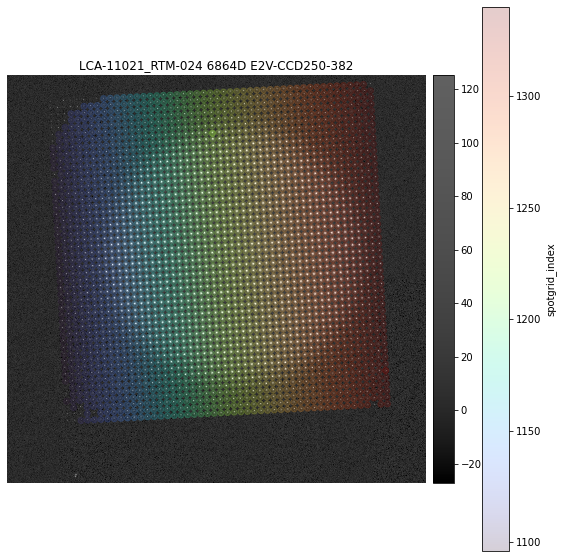

In [5]:
fig = plt.figure(figsize=(10,10))

calexp = subbutler.get("postISRCCD",dataId=aref.dataId)
src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
display(calexp,
        " ".join([ calexp.getMetadata()[a] for a in [ "RAFTNAME", "RUNNUM", "LSST_NUM" ] ])
)
plt.scatter( src["spotgrid_x"],src["spotgrid_y"],
             c = src["spotgrid_index"],cmap='turbo',alpha=0.2)
spotindex = 1218
plt.scatter(src["spotgrid_x"][src["spotgrid_index"]==spotindex],
            src["spotgrid_y"][src["spotgrid_index"]==spotindex],
            c = src["spotgrid_index"][src["spotgrid_index"]==spotindex],
            cmap='turbo',alpha=0.2)

plt.colorbar(label="spotgrid_index")


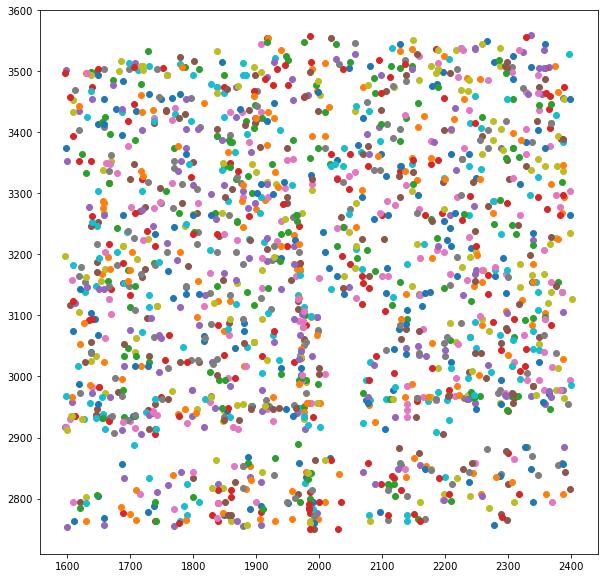

In [6]:
# plot a spot #1200 to see how the spot projector moved
fig = plt.figure(figsize=(10,10))

for aref in datasetRefs:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        cond = src["spotgrid_index"]==spotindex
        plt.scatter(
            src["spotgrid_x"][cond],
            src["spotgrid_y"][cond]            
        )
    except:
#        raise
        pass

In [7]:
results[0]["md"]["BOTX"], results[0]["md"]["BOTY"], results[0]["md"]["BOTXCAM"], results[0]["md"]["BOTYCAM"]

(294.4083511123657, 395.2999783798218, 0.8916488876342328, -2.2999783798217663)

In [8]:
# plot a spot #1200 to see how the spot projector moved

from astropy.table import Table

tab = []
for i, aref in enumerate(datasetRefs):
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        image = subbutler.get("postISRCCD",dataId=aref.dataId)
        md = image.getMetadata()
        cond = src["spotgrid_index"]==spotindex
        
        tab.append(
            {
                "index": i,
                "dataId": aref.dataId,
                "spotgrid_x": src["spotgrid_x"][cond][0],
                "spotgrid_y": src["spotgrid_y"][cond][0],
                "BOTXCAM": md["BOTXCAM"],
                "BOTYCAM": md["BOTYCAM"]
            }
        )

    except:
        pass
tab = Table(tab)

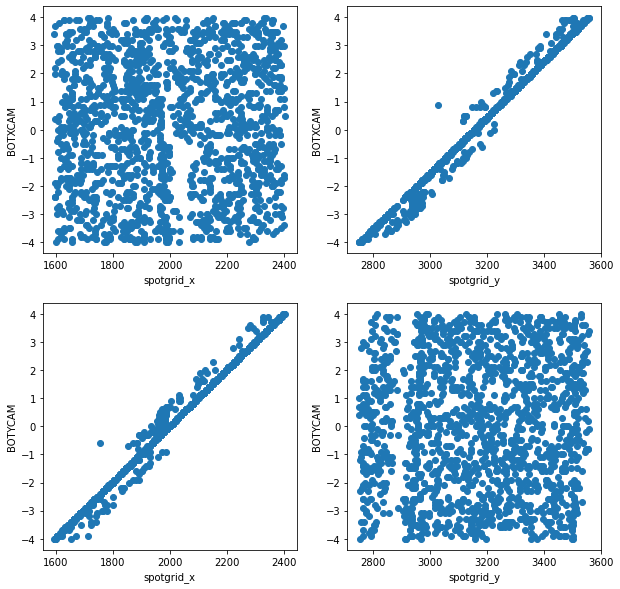

In [9]:
fig = plt.figure(figsize=(10,10))

for i, ( xkey, ykey ) in enumerate(
        [
            ( "spotgrid_x", "BOTXCAM" ),
            ( "spotgrid_y", "BOTXCAM" ),
            ( "spotgrid_x", "BOTYCAM" ),
            ( "spotgrid_y", "BOTYCAM" ),
        ]
    ):
    plt.subplot("22{}".format(i+1))
    plt.scatter(tab[xkey], tab[ykey])
    plt.xlabel(xkey)
    plt.ylabel(ykey)


<ipython-input-40-bae5060a86fc>:16: RuntimeWarning: invalid value encountered in true_divide
  y = (tab[ykey]-tab[ykey][minid])/(tab[xkey]-tab[xkey][minid])


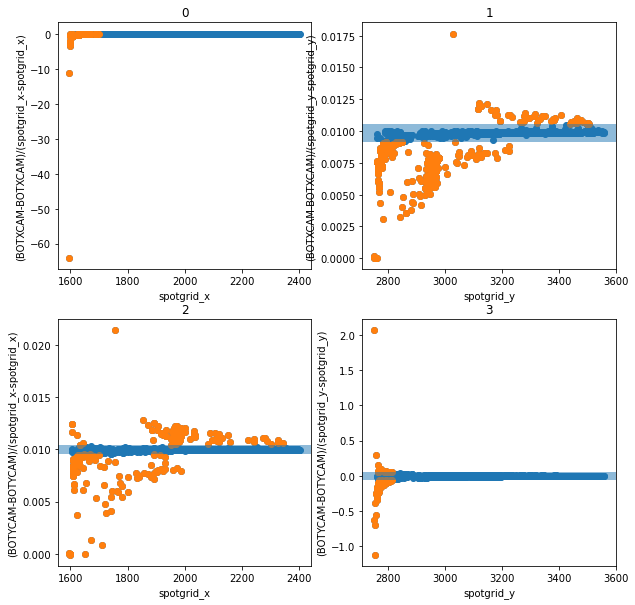

In [40]:
from astropy.stats import median_absolute_deviation as mad
fig = plt.figure(figsize=(10,10))

conds = []
for i, ( xkey, ykey ) in enumerate(
        [
            ( "spotgrid_x", "BOTXCAM" ),
            ( "spotgrid_y", "BOTXCAM" ),
            ( "spotgrid_x", "BOTYCAM" ),
            ( "spotgrid_y", "BOTYCAM" ),
        ]
    ):
    plt.subplot("22{}".format(i+1))

    minid = numpy.argmin(tab[xkey])
    y = (tab[ykey]-tab[ykey][minid])/(tab[xkey]-tab[xkey][minid])
    
    plt.scatter(tab[xkey], y)
    m = numpy.nanmedian(y)
    s = mad(y,ignore_nan=True)
    n = 10
    plt.axhspan(numpy.nanmedian(y)-n*s,numpy.nanmedian(y)+n*s,alpha=0.5)
    cond = numpy.abs(y-m)>n*s
    conds.append(cond)
    plt.title(i)
    plt.scatter(tab[xkey][cond], y[cond])
    plt.xlabel(xkey)
    plt.ylabel("({}-{})/({}-{})".format(ykey,ykey,xkey,xkey))
#    print(tab[cond])

[False False False ... False False False]
MC_C_20191030_001232


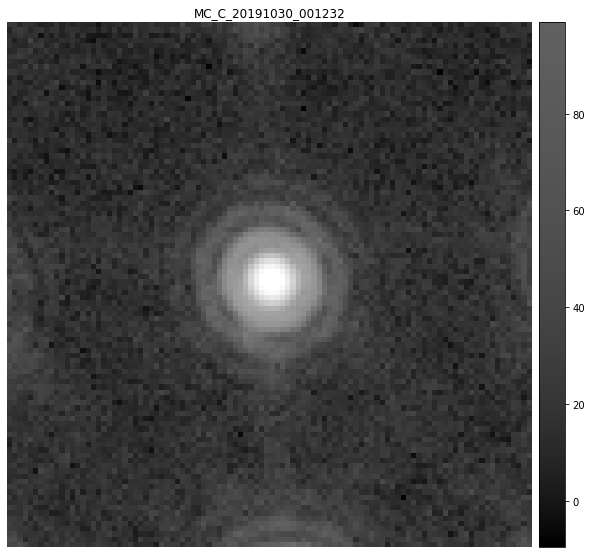

<Figure size 720x720 with 0 Axes>

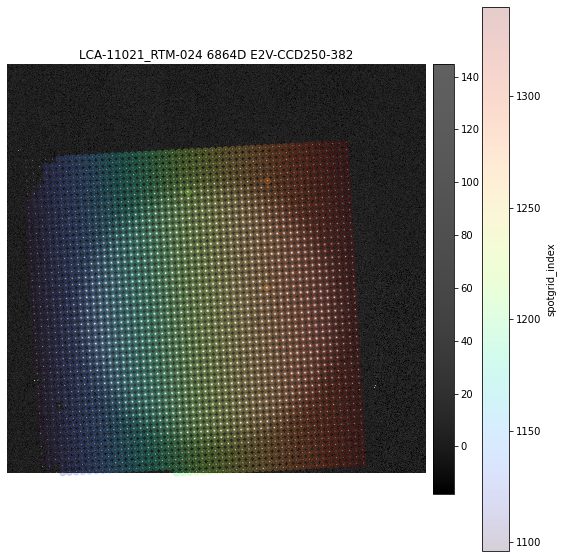

MC_C_20191030_001152


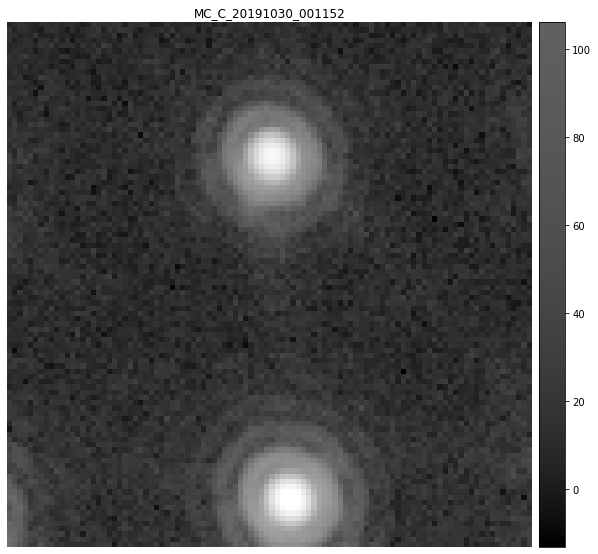

<Figure size 720x720 with 0 Axes>

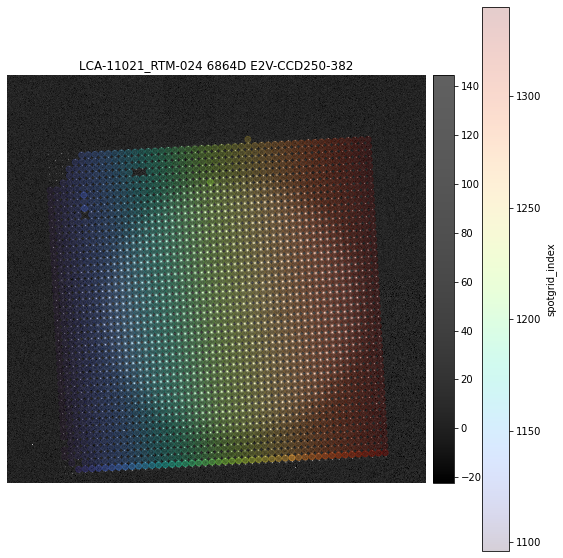

MC_C_20191030_000603


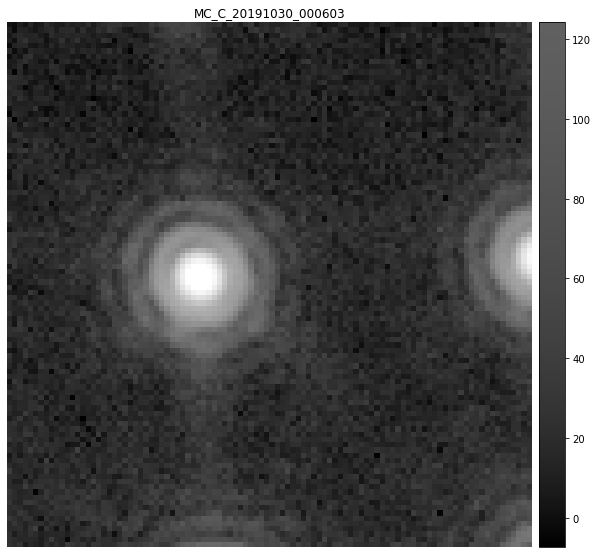

<Figure size 720x720 with 0 Axes>

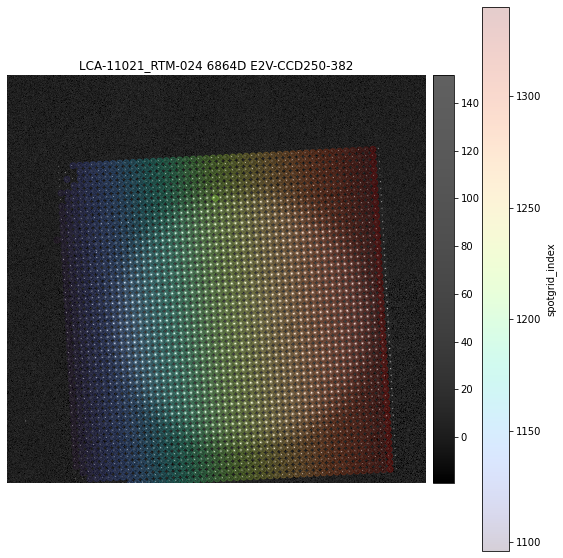

MC_C_20191030_000529


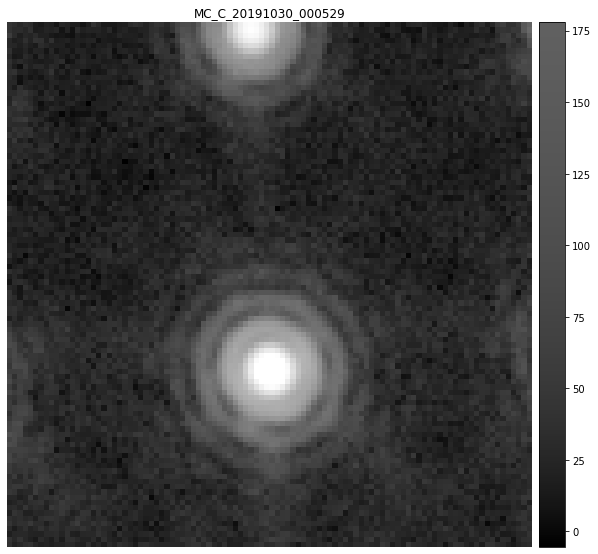

<Figure size 720x720 with 0 Axes>

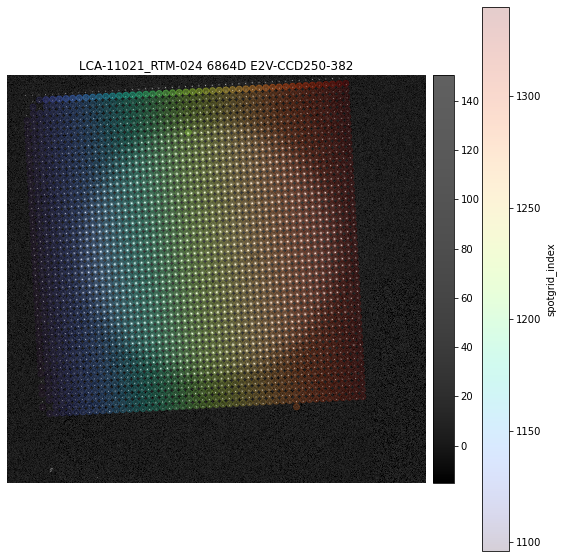

MC_C_20191030_001093


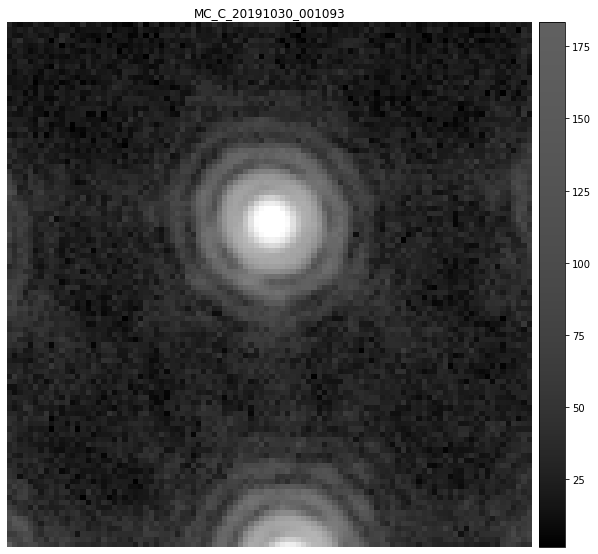

<Figure size 720x720 with 0 Axes>

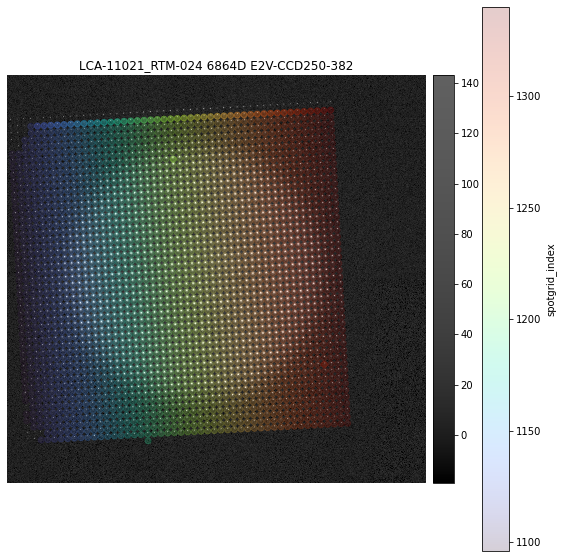

MC_C_20191030_000452


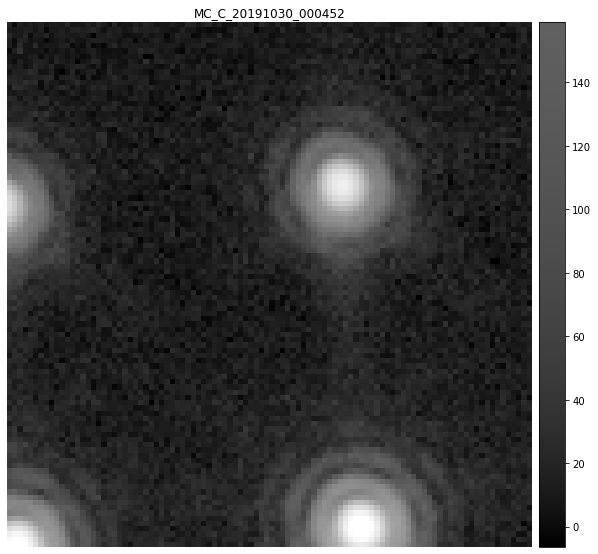

<Figure size 720x720 with 0 Axes>

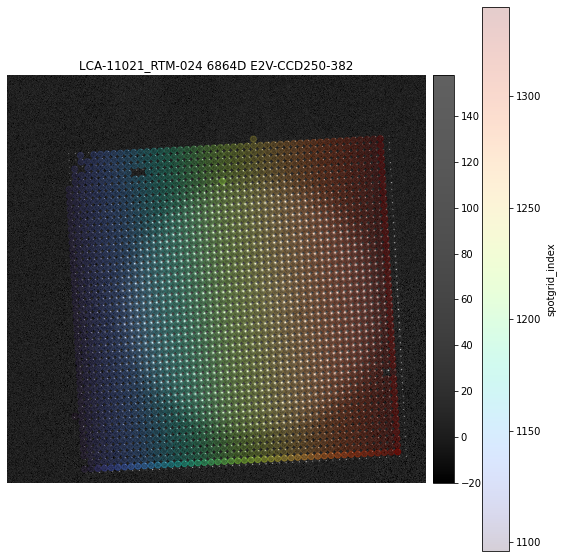

MC_C_20191030_001187


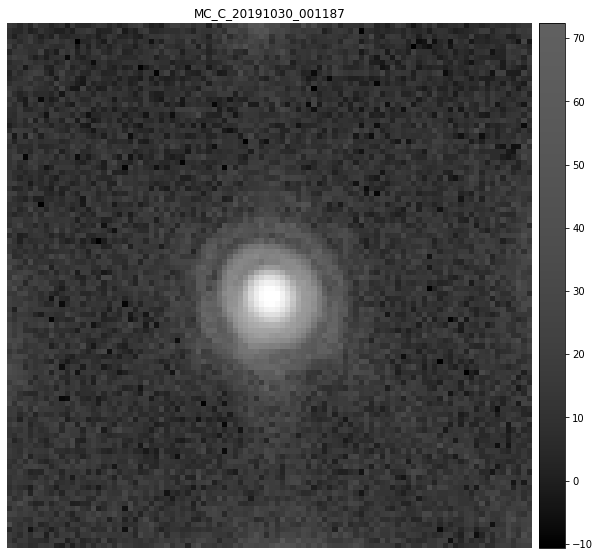

<Figure size 720x720 with 0 Axes>

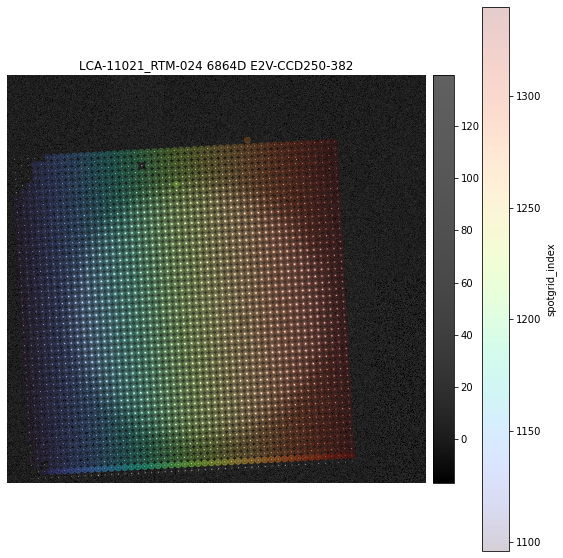

MC_C_20191030_001328


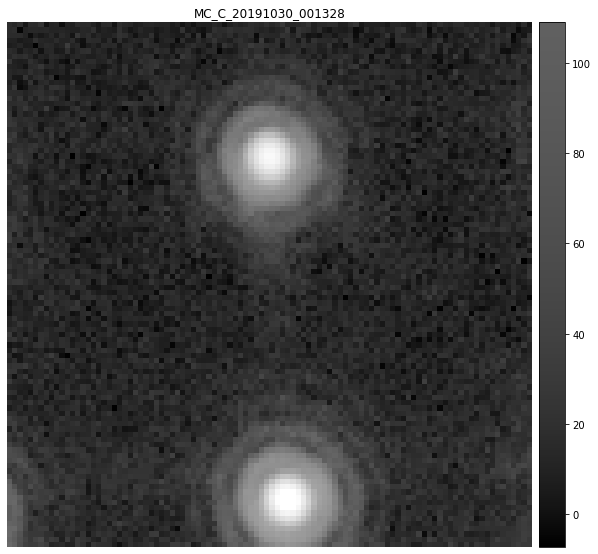

<Figure size 720x720 with 0 Axes>

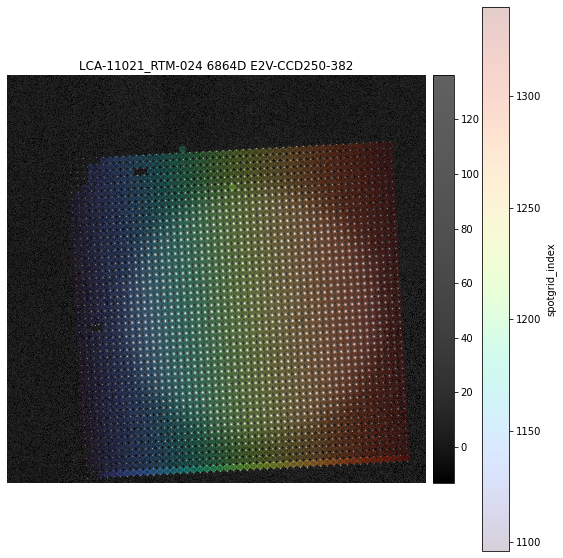

MC_C_20191030_001113


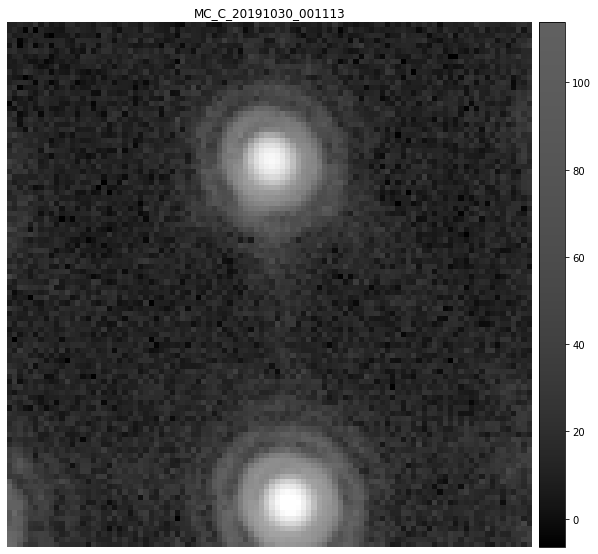

<Figure size 720x720 with 0 Axes>

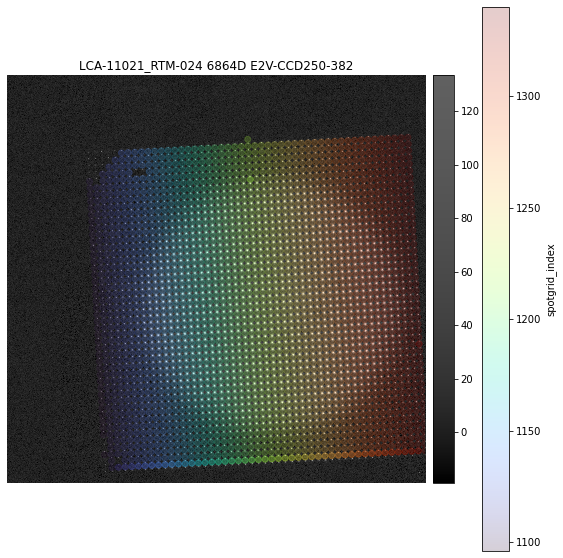

MC_C_20191030_001580


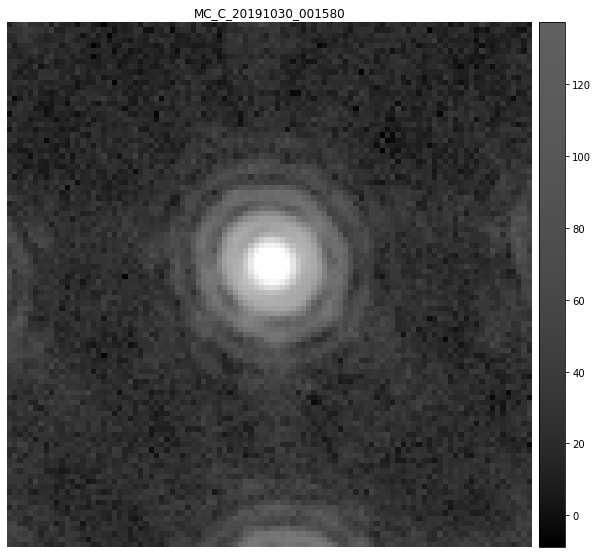

<Figure size 720x720 with 0 Axes>

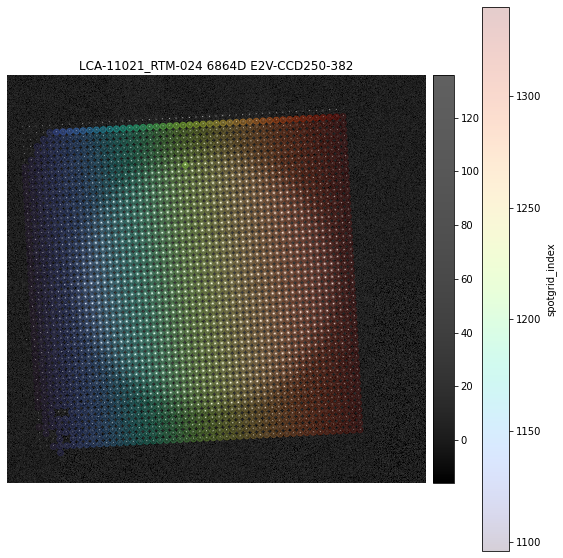

In [88]:
res = []
print(conds[0])
for i in tab[conds[1]]["index"][:10]:
    did=datasetRefs[i].dataId
    image = subbutler.get("postISRCCD",dataId=did)
    print ( image.getMetadata()["OBSID"] )

    x, y = tab[i]["spotgrid_x"], tab[i]["spotgrid_y"]
    d = 50
    display(image[x-d:x+d,y-d:y+d],image.getMetadata()["OBSID"] )
    plt.show()
    
    ### make a rainbow plot
    fig = plt.figure(figsize=(10,10))

    calexp = subbutler.get("postISRCCD",dataId=datasetRefs[i].dataId)
    src = subbutler.get("gridSpotSrc",dataId=datasetRefs[i].dataId)
    display(calexp,
            " ".join([ calexp.getMetadata()[a] for a in [ "RAFTNAME", "RUNNUM", "LSST_NUM" ] ])
    )
    plt.scatter( src["spotgrid_x"],src["spotgrid_y"],
                 c = src["spotgrid_index"],cmap='turbo',alpha=0.2)
    spotindex = 1218
    plt.scatter(src["spotgrid_x"][src["spotgrid_index"]==spotindex],
                src["spotgrid_y"][src["spotgrid_index"]==spotindex],
                c = src["spotgrid_index"][src["spotgrid_index"]==spotindex],
                cmap='turbo',alpha=0.2)

    plt.colorbar(label="spotgrid_index")
    plt.show()
    



In [89]:
for i in tab[conds[1]]["index"]:
    did=datasetRefs[i].dataId
    image = subbutler.get("postISRCCD",dataId=did)
    print ( image.getMetadata()["OBSID"] )


MC_C_20191030_001232
MC_C_20191030_001152
MC_C_20191030_000603
MC_C_20191030_000529
MC_C_20191030_001093
MC_C_20191030_000452
MC_C_20191030_001187
MC_C_20191030_001328
MC_C_20191030_001113
MC_C_20191030_001580
MC_C_20191030_001815
MC_C_20191030_001157
MC_C_20191030_001721
MC_C_20191030_001268
MC_C_20191030_000390
MC_C_20191030_001283
MC_C_20191030_000959
MC_C_20191030_000709
MC_C_20191030_001602
MC_C_20191030_000964
MC_C_20191030_000415
MC_C_20191030_001763
MC_C_20191030_001357
MC_C_20191030_001214
MC_C_20191030_001216
MC_C_20191030_001231
MC_C_20191030_000845
MC_C_20191030_000422
MC_C_20191030_001644
MC_C_20191030_001550
MC_C_20191030_001095
MC_C_20191030_000439
MC_C_20191030_000548
MC_C_20191030_001241
MC_C_20191030_001916
MC_C_20191030_000632
MC_C_20191030_001273
MC_C_20191030_001416
MC_C_20191030_000538
MC_C_20191030_000773
MC_C_20191030_001431
MC_C_20191030_001102
MC_C_20191030_000882
MC_C_20191030_001707
MC_C_20191030_001841
MC_C_20191030_000983
MC_C_20191030_000798
MC_C_20191030